# 1. Setup

In [11]:
import contextily as ctx
from scipy.spatial import KDTree
import urllib.request
import yaml

from utils import *

# 2. Prepare zones

## 2.1. TIGER/Line zones

Download the zone boundary shapefiles for the continental U.S. (lower 48 + DC) for the relevant spatial scales for **2010** and **2020**. However, due to how the TIGER database handles stuff before 2010, the 2011 data is used instead of 2010.

In [2]:
stateCodes = pd.read_csv(DATA / 'zones/state_codes.csv').disp()

49 rows x 3 cols; Memory: 0.0 MiB


,name,code,fips
,<object>,<object>,<int64>
0,Alabama,AL,1


In [3]:
def get_us_shp(scale, year, stateCodes=stateCodes, overwrite=False):
    """Download or load the boundary shapefile of all the US 
    Census regions at the given scale and the given year.
    """
    assert scale in ['bg', 'cbsa', 'county', 'place', 'state', 'tract'], scale
    outpath = DATA / f'zones/tiger/{scale}_{year}.parquet'
    if outpath.exists() and not overwrite:
        return gpd.read_parquet(outpath).set_crs(CRS_DEG)
    year_ = max(year, 2011) # to fix the 2010 vs 2011 issue
    baseUrl = ('https://www2.census.gov/geo/tiger/TIGER{}/{}'
               .format(year_, scale.upper()))
    # for scales available only for the entire US
    if scale in ['cbsa', 'county', 'state']:
        files = [f'tl_{year_}_us_{scale}.zip']
    else: # for scales available only at the state level
        files = [f'tl_{year_}_{fips:02}_{scale}.zip'
                 for fips in stateCodes['fips']]
    df = pd.concat([gpd.read_file(f'{baseUrl}/{f}') for f in files])
    df = df.to_crs(CRS_DEG).rename(columns=str.lower)
    if 'name' not in df.columns:
        df['name'] = ''
    df = df[['geoid', 'name', 'aland', 'awater', 'geometry']]
    df = df.sort_values('geoid').reset_index(drop=True)
    df.to_parquet(mkfile(outpath), compression='gzip')
    return df

# get_us_shp('state', 2010, overwrite=1) # 2s
# get_us_shp('state', 2020, overwrite=1) # 2s
# get_us_shp('cbsa', 2010, overwrite=1) # 5s
# get_us_shp('cbsa', 2020, overwrite=1) # 5s
# get_us_shp('county', 2010, overwrite=1) # 11s
# get_us_shp('county', 2020, overwrite=1) # 12s
# get_us_shp('place', 2010, overwrite=1) # 1m24s
# get_us_shp('place', 2020, overwrite=1) # 1m40s
# get_us_shp('tract', 2010, overwrite=1) # 58s
# get_us_shp('tract', 2020, overwrite=1) # 1m4s
# get_us_shp('bg', 2010, overwrite=1) # 1m37s
# get_us_shp('bg', 2020, overwrite=1) # 1m45s
cnty20 = get_us_shp('county', 2020).disp() # 12s

3,234 rows x 5 cols; Memory: 0.5 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,name,aland,awater,geometry
,<object>,<object>,<int64>,<int64>,<geometry>
0,01001,Autauga,1539634184,25674812,"POLYGON ((-86.903096 32.540626, -86.903115 32...."


## 2.2. Remove waters
The original US counties and states layers include areas with only water and no land. They don't look good for mapping purposes, so instead combine tracts (which don't include waters) to counties and states.

In [4]:
def remove_waters(scale, year, overwrite=False):
    outpath = DATA / f'zones/tiger/{scale}_{year}_nowater.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    df = pd.read_parquet(DATA / f'zones/tiger/{scale}_{year}.parquet',
                         columns=['geoid', 'name', 'aland', 'awater'])
    tr = gpd.read_parquet(DATA / f'zones/tiger/tract_{year}.parquet', filters=[
        ('aland', '>', 0)], columns=['geoid', 'geometry'])
    nChar = D(county=5, state=2)[scale]
    tr['geoid'] = tr['geoid'].str[:nChar]
    tr = tr.dissolve('geoid').reset_index()
    df = tr.merge(df, on='geoid')
    df = df[['geoid', 'name', 'aland', 'awater', 'geometry']]
    df.to_parquet(mkfile(outpath))
    return df

# x = remove_waters('county', 2020); x # 1m28s
# x = remove_waters('county', 2010); x # 1m17s
# x = remove_waters('state', 2010); x # 1m41s
# x = remove_waters('state', 2020); x # 1m52s

## 2.3. Urban areas

In [5]:
def get_urban_areas(overwrite=False):
    outpath = DATA / 'zones/urban_areas_2020.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    url = 'https://www2.census.gov/geo/docs/reference/ua/2020_UA_BLOCKS.txt'
    df = pd.read_csv(url, sep='|', encoding_errors='replace')
    df = df.rename(columns={'2020_UA_NAME': 'urba', 'GEOID': 'geoid'})
    df.geoid = df.geoid.astype(str).str.zfill(15)
    res = []
    for scale, nchar in [('Tract', 11), ('BG', 12)]:
        d = df.assign(geoid=df.geoid.str[:nchar])
        d = d.groupby(['urba', 'geoid']).size().rename('n').reset_index()
        d = d.sort_values('n', ascending=0).drop_duplicates('geoid')
        res.append(d.assign(scale=scale).sort_values('geoid'))
    df = pd.concat(res).reset_index(drop=1)
    df = df.astype(D(urba=CAT, scale=CAT))[['urba', 'scale', 'geoid']]
    df.to_parquet(mkfile(outpath))
    return df

urba = get_urban_areas(overwrite=0).disp() # 12s

273,434 rows x 3 cols; Memory: 18.9 MiB


,urba,scale,geoid
,<category>,<category>,<object>
0,"Montgomery, AL",Tract,01001020100


### 2.3.1. Largest metro areas
Select the top 50 most populous Metropolitan Statistical Areas (MSAs) for access data preparation. To do this, compute each MSA's population by adding the population of all its constituent BGs, sort them by population and select the top MSAs.

In [6]:
topMSAs = (
    pd.read_parquet(DATA / 'ses/acs/acs_2021.parquet', filters=[
        ('scale', '==', 'BG')], columns=['geoid', 'popu'])
    .merge(urba, on='geoid')
    .groupby('urba')['popu'].sum().astype(int)
    .sort_values(ascending=False).reset_index()
    .head(50)
    .assign(msa=lambda df: [x.split(',')[0].split('-')[0]
                            .split('/')[0] for x in df['urba']])
).disp()

50 rows x 3 cols; Memory: 0.2 MiB


,urba,popu,msa
,<category>,<int64>,<object>
0,"New York--Jersey City--Newark, NY--NJ",19448016,New York


## 2.4. Combine attributes

In [7]:
def get_zones(year, urba=urba, top_msas=topMSAs,
              state_codes=stateCodes, overwrite=False):
    outpath = DATA / f'zones/zones_{year}.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    assert year in [2010, 2020], year
    df = pd.concat([get_us_shp(scale, year).assign(scale=label)
                    for scale, label in [('tract', 'Tract'), ('bg', 'BG')]])
    df = df.merge(urba.astype({'urba': str}), 'left', on=('geoid', 'scale'))
    df['cnty_id'] = df.geoid.str[:5]
    cnty = (gpd.read_parquet(DATA / f'zones/tiger/county_{year}_nowater.parquet')
            .rename(columns={'name': 'county', 'geoid': 'cnty_id'}))
    df = df.merge(cnty[['cnty_id', 'county']], on='cnty_id')
    cnty2urba = (df.groupby(['urba', 'cnty_id'])['aland'].sum()
                 .sort_values(ascending=0).reset_index()
                 [['cnty_id', 'urba']].drop_duplicates(['cnty_id']))
    cnty = cnty.merge(cnty2urba, 'left', on='cnty_id')
    cnty = cnty.rename(columns={'cnty_id': 'geoid'}).assign(scale='County')
    df = pd.concat([cnty, df])
    df = df.merge(top_msas.astype(D(urba=str)), 'left', on='urba')
    df['fips'] = df.geoid.str[:2].astype(int)
    df = df.merge(state_codes.rename(columns={'code': 'state'}), on='fips')
    df['aland'] *= SQM2SQMI; df['awater'] *= SQM2SQMI
    df = df.astype(D(scale=CAT, state=CAT, county=CAT, urba=CAT, msa=CAT,
                     aland=F32, awater=F32))
    df['top_msa'] = ~df['msa'].isna()
    df = df.to_crs(CRS_M)['geoid scale state county urba top_msa '
                          'msa aland awater geometry'.split()]
    df.to_parquet(mkfile(outpath), compression='gzip')
    return df

zones20 = get_zones(2020).disp() # 1m4s

325,077 rows x 10 cols; Memory: 29.2 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,state,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>
0,01001,County,AL,Autauga,"Montgomery, AL",False,NaN,594.453369,9.913054,"POLYGON ((-9624353.111696 3816718.739514, -962..."


In [8]:
zones10 = get_zones(2010).disp(0) # 2m9s

291,977 rows x 10 cols; Memory: 26.2 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,state,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>


## 2.5. Export for OSRM

In [9]:
def get_zone_centroids(level, year=2020, overwrite=False):
    outpath = DATA / f'zones/osrm_export/{level}_{year}.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    path = DATA / f'zones/zones_{year}.parquet'
    cols = ['geoid', 'scale', level, 'geometry']
    if level == 'msa':
        df = gpd.read_parquet(path, columns=cols,
                              filters=[('top_msa', '==', True)])
    else:
        df = gpd.read_parquet(path, columns=cols)
    df = df.rename(columns={level: 'region'})
    df.geometry = df.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
    xy = df.geometry.get_coordinates()
    xy.columns = ['centerx', 'centery']
    df = pd.concat([df[['geoid', 'scale', 'region']], xy], axis=1)
    df.to_parquet(mkfile(outpath))
    return df

msaPts = get_zone_centroids('msa', overwrite=0).disp() # 13s
# statePts10 = get_zone_centroids('state', 2010, overwrite=0).disp(0) # 19s
# statePts20 = get_zone_centroids('state', overwrite=0).disp(0) # 20s

144,489 rows x 5 cols; Memory: 12.0 MiB


,geoid,scale,region,centerx,centery
,<object>,<category>,<category>,<float64>,<float64>
0,04013,County,Phoenix,-112.490651,33.351998


## 2.6. Crosswalk
[Relationship files](https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.2020.html) show the mapping between the old (2010) and the new (2020) zones for [block groups](https://www2.census.gov/geo/docs/maps-data/data/rel2020/blkgrp/tab20_blkgrp20_blkgrp10_natl.txt), [tracts](https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt), [counties](https://www2.census.gov/geo/docs/maps-data/data/rel2020/cousub/tab20_cousub20_cousub10_natl.txt).

### 2.6.1. Area overlaps

In [10]:
def get_census_crosstab_2010_2020(overwrite=False):
    """Create the relationship crosswalk matrix file between the 
    years 2010 and 2020 for the given state at the given scale."""
    outpath = DATA / 'zones/crosstab_2010_2020.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    baseUrl = 'https://www2.census.gov/geo/docs/maps-data/data/rel2020'
    res = []
    for scale, key, nchar in [('Tract', 'tract', 11),
                              ('BG', 'blkgrp', 12)]:
        url = f'{baseUrl}/{key}/tab20_{key}20_{key}10_natl.txt'
        df = pd.read_csv(url, sep='|').rename(columns=str.lower)
        df = df.rename(columns=lambda x: x.replace('_' + key, ''))
        df.geoid_10 = df.geoid_10.astype(str).str.zfill(nchar)
        df.geoid_20 = df.geoid_20.astype(str).str.zfill(nchar)
        df = df[['geoid_10', 'geoid_20', 'arealand_10',
                 'arealand_20', 'arealand_part', 'areawater_10',
                 'areawater_20', 'areawater_part']].dropna()
        df.insert(0, 'scale', scale)
        res.append(df)
    res = pd.concat(res).reset_index(drop=True).astype(D(scale=CAT))
    res.to_parquet(mkfile(outpath))
    return res

xtab = get_census_crosstab_2010_2020(overwrite=0).disp() # 3s

463,776 rows x 9 cols; Memory: 82.5 MiB


,scale,geoid_10,geoid_20,arealand_10,arealand_20,arealand_part,areawater_10,areawater_20,areawater_part
,<category>,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,Tract,01001020100,01001020100,9827271,9825304,9820448,28435,28435,28435


### 2.6.2. Mapping based on centroid

In [15]:
def get_zone_map10to20(zones10=zones10, zones20=zones20, overwrite=False):
    outpath = DATA / 'zones/mapping_2010_2020.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    xy10 = zones10.assign(geometry=zones10.centroid).get_coordinates()
    xy20 = zones20.assign(geometry=zones20.centroid).get_coordinates()
    zones10 = pd.concat([zones10[['geoid', 'scale']], xy10], axis=1)
    zones20 = pd.concat([zones20[['geoid', 'scale']], xy20], axis=1)
    res = []
    for scale in ['County', 'Tract', 'BG']:
        z10 = zones10.query('scale==@scale').set_index('geoid')
        z20 = zones20.query('scale==@scale').set_index('geoid')
        tree = KDTree(z10[['x', 'y']])
        _, idx = tree.query(z20[['x', 'y']])
        df = Pdf(D(geoid_10=z10.index[idx], geoid_20=z20.index))
        res.append(df.assign(scale=scale))
    df = pd.concat(res).reset_index(drop=1)
    df.to_parquet(mkfile(outpath))
    return df

map10to20 = get_zone_map10to20(overwrite=0).disp() # 10s

325,077 rows x 3 cols; Memory: 61.1 MiB


,geoid_10,geoid_20,scale
,<object>,<object>,<object>
0,01001,01001,County


# 3. OSM database

## 3.1. Download

### 3.1.1. Census regions

In [10]:
def download_region_db(name, overwrite=False):
    name = name.lower().replace(' ', '-')
    assert name in ['midwest', 'northeast', 'pacific', 'south', 'west'], name
    outpath = DATA / f'osm/region/{name}.osm.pbf'
    if outpath.exists() and not overwrite:
        return
    baseUrl = 'https://download.geofabrik.de/north-america'
    url = f'{baseUrl}/us-{name}-latest.osm.pbf'
    urllib.request.urlretrieve(url, mkfile(outpath))

# download_region_db('pacific')

### 3.1.2. States

In [11]:
def download_state_db(name, overwrite=False):
    name = name.lower().replace(' ', '-')
    outpath = DATA / f'osm/state/{name}/{name}.osm.pbf'
    if outpath.exists() and not overwrite:
        return
    baseUrl = 'https://download.geofabrik.de/north-america/us'
    url = f'{baseUrl}/{name}-latest.osm.pbf'
    urllib.request.urlretrieve(url, mkfile(outpath))

# for state in tqdm(mk.geo.US_STATES_FIPS.keys()):
#     download_state_db(state)

### 3.1.3. Extract regional database

In [12]:
# %%bash
# #! long time to run
# cd ../data/osm/region
# for rgn in midwest northeast south west; do
#     outfile=$rgn.osm
#     if [ -f $outfile ]; then osmium cat $rgn.osm.pbf -o $outfile; fi
# done

## 3.2. Extract for MSAs

### 3.2.1. Prepare MSA lists
The 50 largest MSAs were manually assigned a US region label to allow extracting the MSA OSM database from the regional OSM extract instead of the state's extract since an MSA can span multiple states but lies in only one region.

In [16]:
with open(DATA / 'osm/msa2region.yml', 'r') as f:
    msa2rgn = yaml.safe_load(f)

msa2rgn = Series(msa2rgn, name='region').rename_axis('cbsa').reset_index().disp(2)

50 rows x 2 cols; Memory: 0.0 MiB


,cbsa,region
,<object>,<object>
0,"Atlanta-Sandy Springs-Roswell, GA",south
1,"Austin-Round Rock-San Marcos, TX",south


### 3.2.2. Prepare GeoJSON
Save the GeoJSON file of each MSA's boundary for the corresponding region for the `osmium extract` command to work.

In [15]:
def get_msa_json(year=2020, msa2rgn=msa2rgn, top_msas=topMSAs):
    msa = top_msas.merge(msa2rgn, on='cbsa').rename(
        columns=D(geoid='cbsa_id'))[['cbsa_id', 'key', 'region']]
    df = gpd.read_parquet(DATA / f'zones/zones_{year}.parquet',
                          filters=[('scale', '==', 'county')])
    df = df.merge(msa, on='cbsa_id')
    df = df[['key', 'region', 'geometry']]
    df = df.dissolve('key').reset_index()
    # for multipolygon features, keep only the largest polygon for simplicity
    df = df.explode(subset='geometry', index_parts=True)
    df['area'] = df.to_crs(CRS_M).area
    df = df.sort_values('area').groupby('key').last()
    for key, r in df.iterrows():
        outpath = DATA / f'osm/msa/json/{r.region}/{key}.geojson'
        df = Gdf(r.to_frame().T, crs=CRS_DEG)
        df.to_file(mkfile(outpath), driver='GeoJSON')

# get_msa_json() # t=0:14

### 3.2.3. Extract MSA database by region

In [17]:
%%bash
function get_msa_osm { # [us_region]
    root=../data/osm
    declare -a rgns=('midwest' 'northeast' 'south' 'west')
    # for each MSA in the JSON file directory
    if ! [[ ${rgns[@]} =~ $1 ]]; then
        echo "Error: US region $1 not appropriate."
        exit 1
    fi
    mkdir -p $root/msa/osm
    for fjson in $root/msa/json/$1/*; do
        # get the CBSA key (geoid+name) from the JSON file
        fname=$(basename $fjson)
        cbsa=${fname%.*}
        # resolve the output folder for this MSA
        outdir=$root/msa/pbf/$cbsa
        mkdir -p $outdir
        # define the temporary OSM and output PBF files
        temp=$root/msa/osm/$cbsa.osm
        outfile=$outdir/$cbsa.osm.pbf
        # proceed only if the outfile does not exist
        if ! [ -f $outfile ]; then
            echo "Processing $1 $cbsa"
            # extract the MSA file from the regional file using polygon
            osmium extract -p $fjson $root/region/$1.osm -o $temp
            # compress the extracted MSA database file
            osmium cat $temp -o $outfile
            # remove the large MSA extract (temporary file)
            rm $temp
        else
            echo "Skipping $1 $cbsa"
        fi
    done
}
#! CAUTION: Took a long time to run (t>10 hours!)
# get_msa_osm midwest
# time for rgn in midwest northeast south west; do get_msa_osm $rgn; done

# 4. Visualize

## 4.1. Area distributions

In [18]:
# def plot_area_distr(zones, amax=D(COUNTY=2000, TRACT=100, BG=50),
#                     cmap='Set1', psize=(3, 2.5), dpi=150):
#     ncol = zones['scale'].nunique()
#     colors = sns.color_palette(cmap, ncol)
#     _, axes = plt.subplots(1, ncol, dpi=dpi, figsize=(psize[0] * ncol, psize[1]))
#     for (scale, df), ax, color in zip(zones.groupby('scale', sort=False), axes, colors):
#         ax = U.plot(ax, title=scale, ylab='No. of zones', xlab='Land area (sq. mi.)')
#         x = (df.aland * U.SQM2SQMI).clip(0, amax[scale])
#         x.hist(ax=ax, bins=50, color=color)
#     plt.tight_layout()

# plot_area_distr(zoneIN10)

In [19]:
# plot_area_distr(zoneMSA10)

## 4.2. Map

In [20]:
msa20 = (gpd.read_parquet(DATA / 'zones/zones_2020.parquet', filters=[
    ('top_msa', '==', True), ('scale', '==', 'Tract')])
         [['msa', 'geometry']].dissolve('msa').reset_index()).disp() # 28s

50 rows x 2 cols; Memory: 0.0 MiB; <Projected CRS: EPSG:3857>


,msa,geometry
,<category>,<geometry>
0,Atlanta,"POLYGON ((-9456011.658897 3929034.468802, -945..."


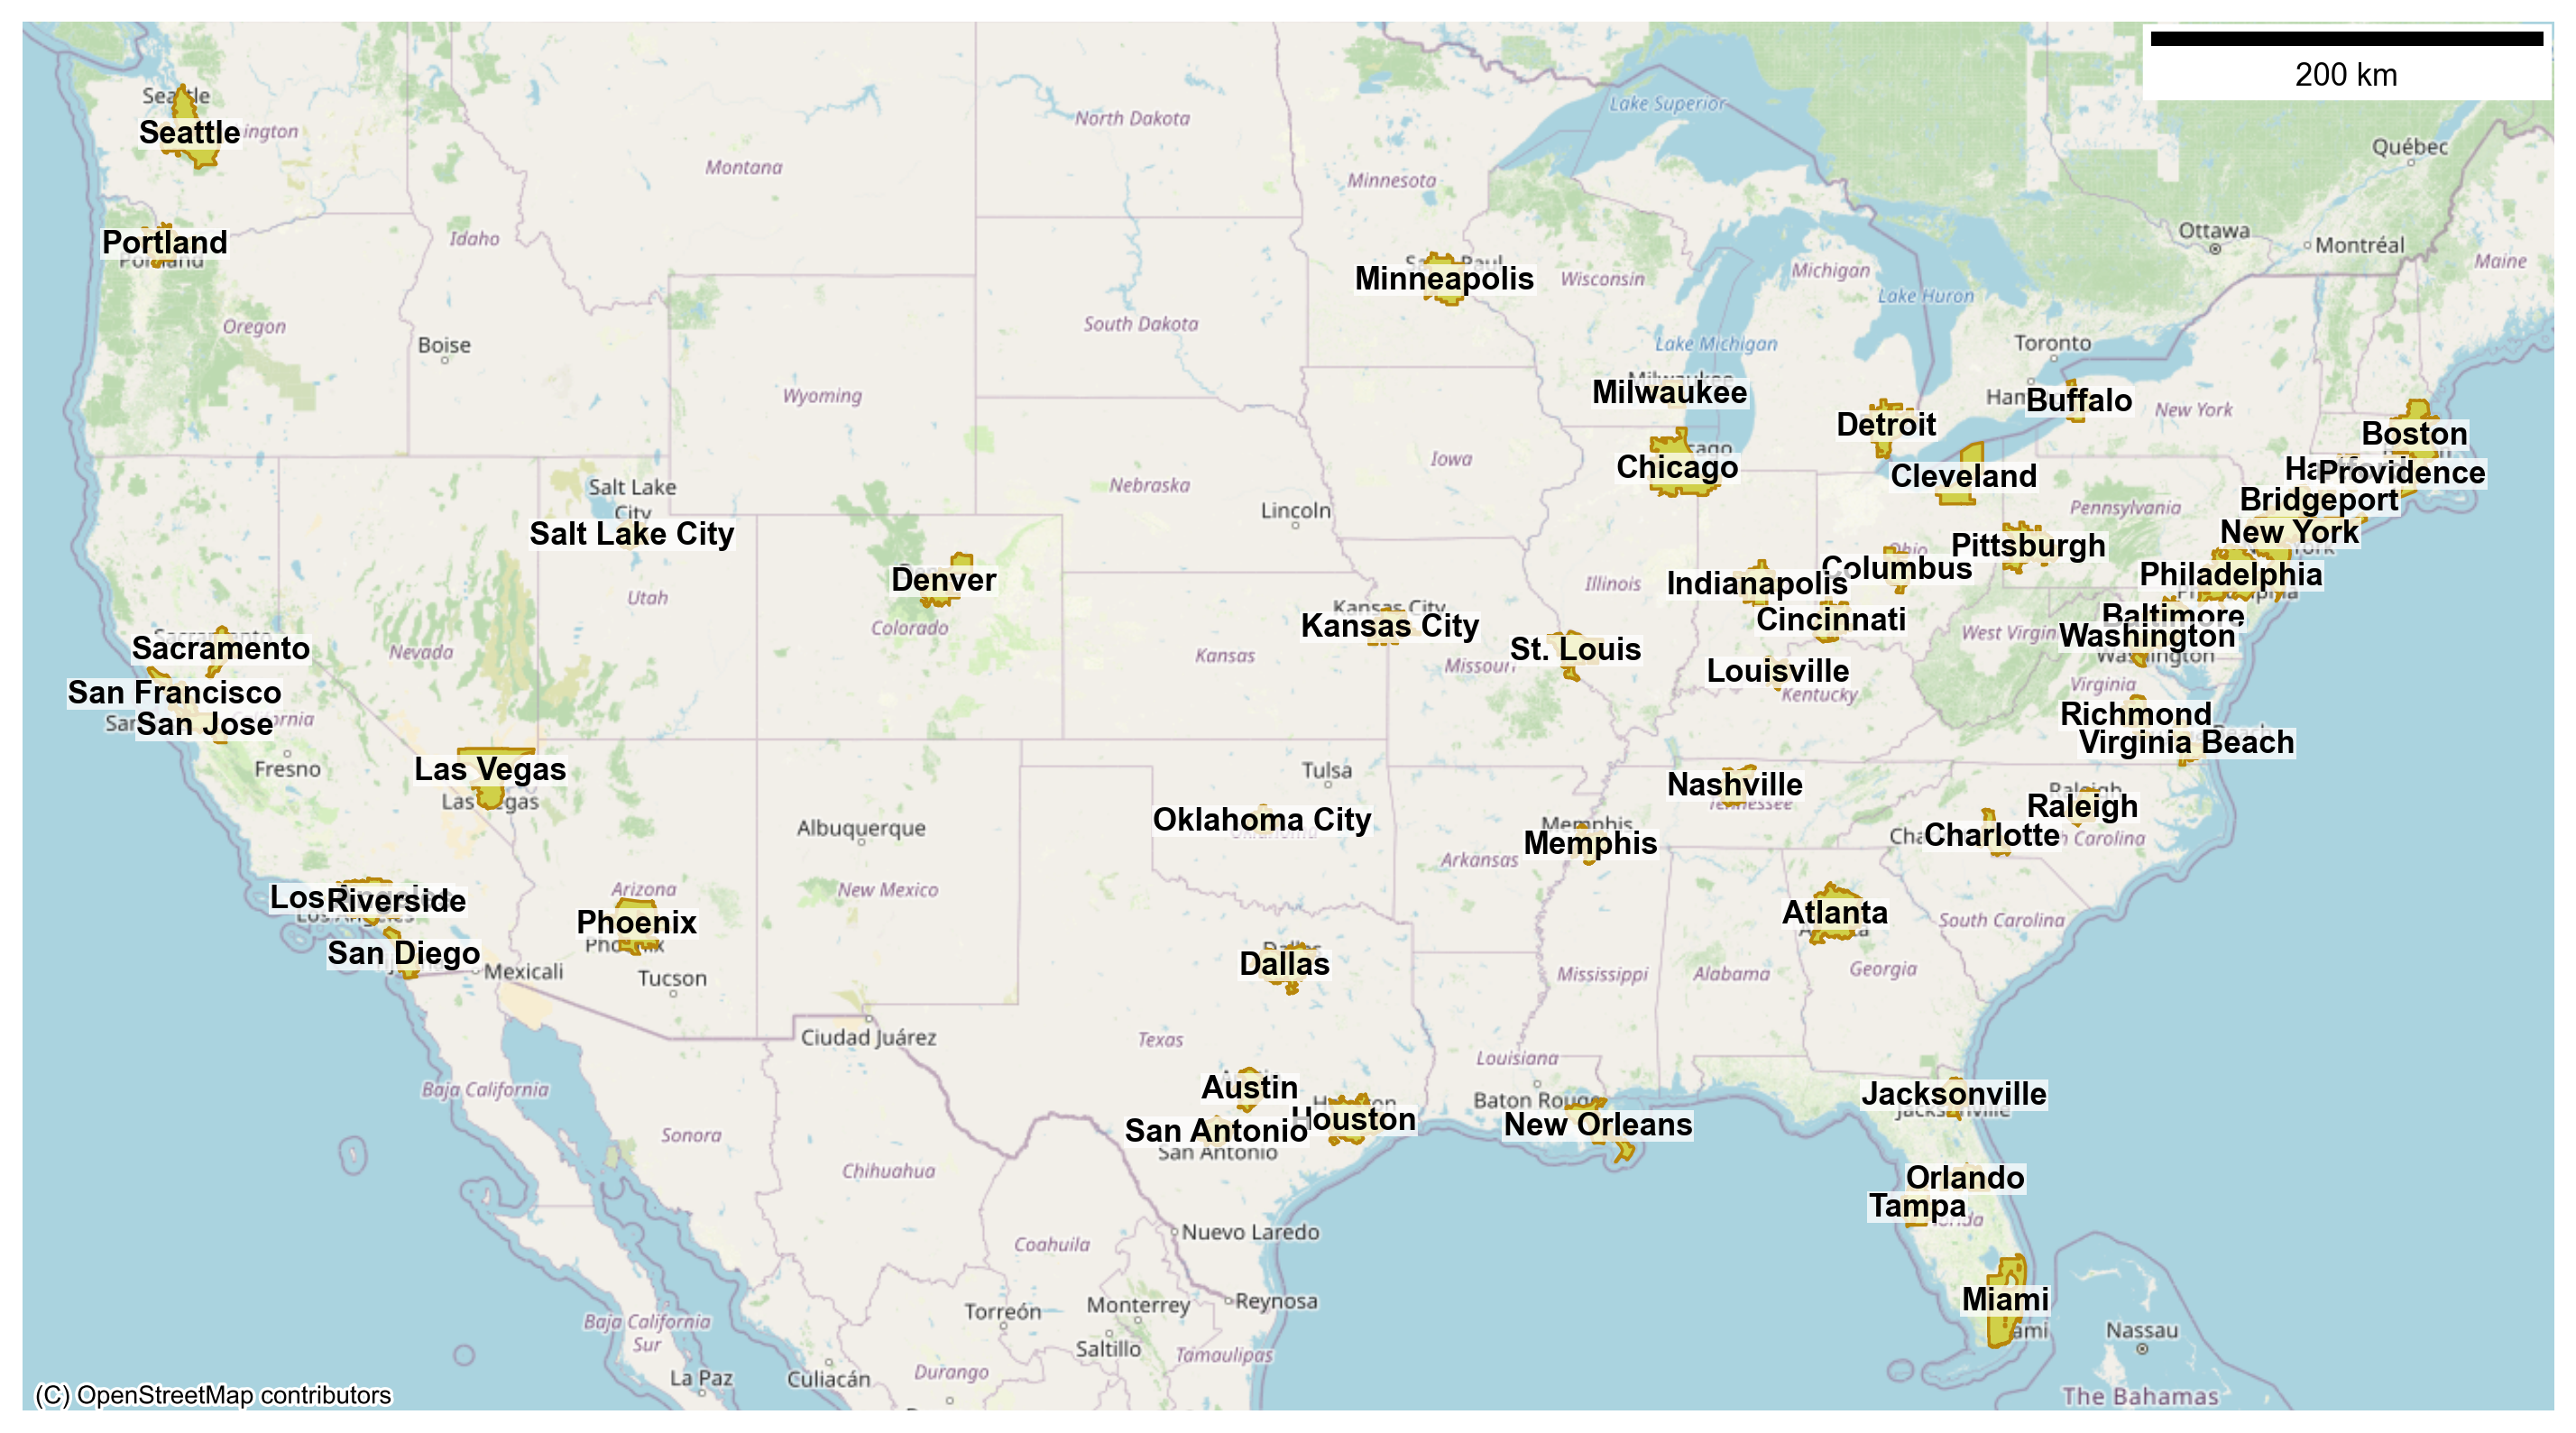

In [21]:
xy = msa20.centroid.get_coordinates()
df = pd.concat([msa20, xy], axis=1)
ax = pplot(size=(20, 8), dpi=250, axoff=1)
df.plot(ax=ax, color='#D0D048', ec='#B8860B', lw=1)
for _, r in df.iterrows():
    ax.text(r.x, r.y, r.msa, fontweight='bold', 
            ha='center', va='center', fontsize=10,
            bbox=D(fc='w', ec='none', pad=0.3, alpha=0.75))
basemap(ax); # 3s